In [3]:
import json
import pandas as pd
import numpy as np

# --- Load data ---
with open("/Users/user/XG/WSL 2526/2025-09-28_West Ham United WFC - Chelsea FC Women.json", "r") as f:
    match = json.load(f)

events = match["event"]
df = pd.DataFrame(events)

# --- Basic cleaning ---
df["team"] = df["contestantId"]
df["x"] = pd.to_numeric(df.get("x"), errors="coerce")
df["y"] = pd.to_numeric(df.get("y"), errors="coerce")

# --- Possession Segmentation ---
plays = []
current_play = []
current_team = None

for _, row in df.iterrows():
    team = row["team"]
    if current_team is None:
        current_team = team

    # Change of possession if team switches or restart-type event occurs
    if team != current_team or row["typeId"] in [1, 2, 3, 4, 5]:
        if current_play:
            plays.append(current_play)
        current_play = [row.to_dict()]
        current_team = team
    else:
        current_play.append(row.to_dict())

if current_play:
    plays.append(current_play)

# --- Metric Functions ---

def play_success_rate(play):
    """Binary: did the play reach the final third or create a shot?"""
    xs = [e.get("x", 0) for e in play if e.get("x") is not None]
    final_third = any(x > 66 for x in xs)
    shot = any(e["typeId"] in [13, 14, 15] for e in play)
    return 1 if (final_third or shot) else 0


def extract_xg(play):
    """Extract xG-like qualifier or estimate a small heuristic fallback."""
    for e in play:
        if "qualifier" in e:
            for q in e["qualifier"]:
                if q.get("qualifierId") == 213:  # xG-like qualifier
                    val = float(q.get("value", 0))
                    return min(val, 1.0)
    # Fallback heuristic if no xG data
    shot_event = next((e for e in play if e["typeId"] in [13, 14, 15]), None)
    if shot_event:
        x = shot_event.get("x", 50)
        base_xg = max(0, (x - 50) / 50) * 0.1
        return round(base_xg, 3)
    return 0.0


def expected_play_value(play):
    """Scaled Expected Play Value (xPV) combining progress + xG."""
    xs = [e.get("x", 0) for e in play if e.get("x") is not None]
    if len(xs) < 2:
        return 0.0
    gain = max(xs) - min(xs)

    # Normalize: assume 0–100 scale for pitch x coordinates
    progress_value = (gain / 100) * 0.15  # max 0.15 from buildup
    shot_value = extract_xg(play)          # up to 1.0 from shot

    xpv = progress_value + shot_value
    xpv = round(min(xpv, 1.0), 4)          # cap to 1.0

    # sanity check for bad data
    if xpv > 1:
        print(f"⚠️ Unusual xPV {xpv:.2f} for play: gain={gain:.1f}, shot_value={shot_value}")
    return xpv


def is_explosive(play):
    xs = [e.get("x", 0) for e in play if e.get("x") is not None]
    if not xs:
        return 0
    gain = max(xs) - min(xs)
    return 1 if gain > 25 or expected_play_value(play) > 0.15 else 0


def is_negative(play):
    """Possession ends negatively if last event outcome = 0 (fail/loss)."""
    return 1 if play[-1].get("outcome") == 0 else 0


# --- Collect play-level metrics ---
play_metrics = []
for play in plays:
    team = play[0]["team"]
    psr = play_success_rate(play)
    xpv = expected_play_value(play)
    exp = is_explosive(play)
    neg = is_negative(play)

    players = [e.get("playerId") for e in play if e.get("playerId")]
    player_names = [e.get("playerName") for e in play if e.get("playerName")]

    play_metrics.append({
        "team": team,
        "PSR": psr,
        "xPV": xpv,
        "explosive": exp,
        "negative": neg,
        "players": players,
        "player_names": player_names
    })

metrics_df = pd.DataFrame(play_metrics)

# --- Team-level summary ---
team_summary = metrics_df.groupby("team").agg(
    Plays=("PSR", "count"),
    Successful_Plays=("PSR", "sum"),
    PSR_Rate=("PSR", "mean"),
    Total_xPV=("xPV", "sum"),
    Avg_xPV=("xPV", "mean"),
    Explosive_Plays=("explosive", "sum"),
    Negative_Plays=("negative", "sum")
).reset_index()

# --- Player-level aggregation ---
player_rows = []
for _, row in metrics_df.iterrows():
    for pid, pname in zip(row["players"], row["player_names"]):
        player_rows.append({
            "playerId": pid,
            "playerName": pname,
            "team": row["team"],
            "PSR": row["PSR"],
            "xPV": row["xPV"],
            "explosive": row["explosive"],
            "negative": row["negative"]
        })

players_df = pd.DataFrame(player_rows)

player_summary = players_df.groupby(["playerId", "playerName", "team"]).agg(
    Plays_Involved=("PSR", "count"),
    PSR_Contribution=("PSR", "mean"),
    xPV_Contribution=("xPV", "sum"),
    Explosive_Involved=("explosive", "sum"),
    Negative_Involved=("negative", "sum")
).reset_index()

# Derived ratios
player_summary["Explosive_Rate"] = player_summary["Explosive_Involved"] / player_summary["Plays_Involved"]
player_summary["Negativity_Rate"] = player_summary["Negative_Involved"] / player_summary["Plays_Involved"]

# Clip extreme values just in case
player_summary["xPV_Contribution"] = player_summary["xPV_Contribution"].clip(upper=5)

# Sort by main contribution metric
player_summary = player_summary.sort_values("xPV_Contribution", ascending=False)

# --- Output summaries ---
print("\n🏆 Top 20 Player Contributors (by xPV):\n")
print(player_summary.head(20))

print("\n📊 Team Summary:\n")
print(team_summary)

# --- Save to Excel ---
team_excel_path = "/Users/user/XG/WSL 2526/WestHam_Chelsea_TeamMetrics.xlsx"
player_excel_path = "/Users/user/XG/WSL 2526/WestHam_Chelsea_PlayerMetrics.xlsx"

team_summary.to_excel(team_excel_path, index=False)
player_summary.to_excel(player_excel_path, index=False)

print(f"\n✅ Team metrics saved to: {team_excel_path}")
print(f"✅ Player metrics saved to: {player_excel_path}")



🏆 Top 20 Player Contributors (by xPV):

                     playerId          playerName                       team  \
15  a5ew0j9hz4ounrjkeco7g6iuh             R. Ueki  cz26xwowfjp8ei14n9z2ac135   
14  8h7r4d4z2gjne58xwu3koiok5            K. Walsh   spi3g782q7m4evjxn1sv6cfa   
29  f1xb9y38jfjmrhgv22svv9sa2           A. Denton  cz26xwowfjp8ei14n9z2ac135   
26  e93vn46w6kk9xwdb8forgzil1           V. Asseyi  cz26xwowfjp8ei14n9z2ac135   
25  e3n8fh86gv7xkw2zi6jlqelzp            K. Gorry  cz26xwowfjp8ei14n9z2ac135   
24  dxojafbkfxjskl0ek4nucrnpx           K. Szemik  cz26xwowfjp8ei14n9z2ac135   
23  dtadpzl4ocembhsgou8zjsjjd           F. Morgan  cz26xwowfjp8ei14n9z2ac135   
22  dm9vc2mqtbb982sx6kkd992ax        S. Baltimore   spi3g782q7m4evjxn1sv6cfa   
21  dfeohozpw604y5jbu01u1dkkq         A. Thompson   spi3g782q7m4evjxn1sv6cfa   
19  cs3pg64kurip4uftscemh01k9           A. Tysiak  cz26xwowfjp8ei14n9z2ac135   
18  cij18xj0bx2zyx3mi9xwykn9x         E. Cuthbert   spi3g782q7m4evjxn1sv6cfa   


🏆 Top 20 Player Contributors (by xPV):
                      playerId          playerName                       team  \
1   2m6wew2746q1xsoio3703t8t1  J. Rytting Kaneryd   spi3g782q7m4evjxn1sv6cfa   
12   7np6c6939ms55m37juqvw0oa          W. Kaptein   spi3g782q7m4evjxn1sv6cfa   
2   30pcgn07mnn0sk4jp0t7bx9ed         S. Zadorsky  cz26xwowfjp8ei14n9z2ac135   
16  anghujtc4achyb9mflowgg9n9           M. Bright   spi3g782q7m4evjxn1sv6cfa   
30   ubxdnr5uuwgcj44lytu3abys          V. Buurman   spi3g782q7m4evjxn1sv6cfa   
15  a5ew0j9hz4ounrjkeco7g6iuh             R. Ueki  cz26xwowfjp8ei14n9z2ac135   
21  dfeohozpw604y5jbu01u1dkkq         A. Thompson   spi3g782q7m4evjxn1sv6cfa   
18  cij18xj0bx2zyx3mi9xwykn9x         E. Cuthbert   spi3g782q7m4evjxn1sv6cfa   
14  8h7r4d4z2gjne58xwu3koiok5            K. Walsh   spi3g782q7m4evjxn1sv6cfa   
9   6d8zrjdl4ii8cjpn5vo7emz11          E. Nyström  cz26xwowfjp8ei14n9z2ac135   
17  bnzgfrgoiwlw6boq7e7ngi162            O. Siren  cz26xwowfjp8ei14n9z2ac135   

/opt/anaconda3/lib/python3.12/site-packages/mplsoccer/_pitch_plot.py:167: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  return sns.kdeplot(x=x, y=y, ax=ax, clip=self.kde_clip, **kwargs)


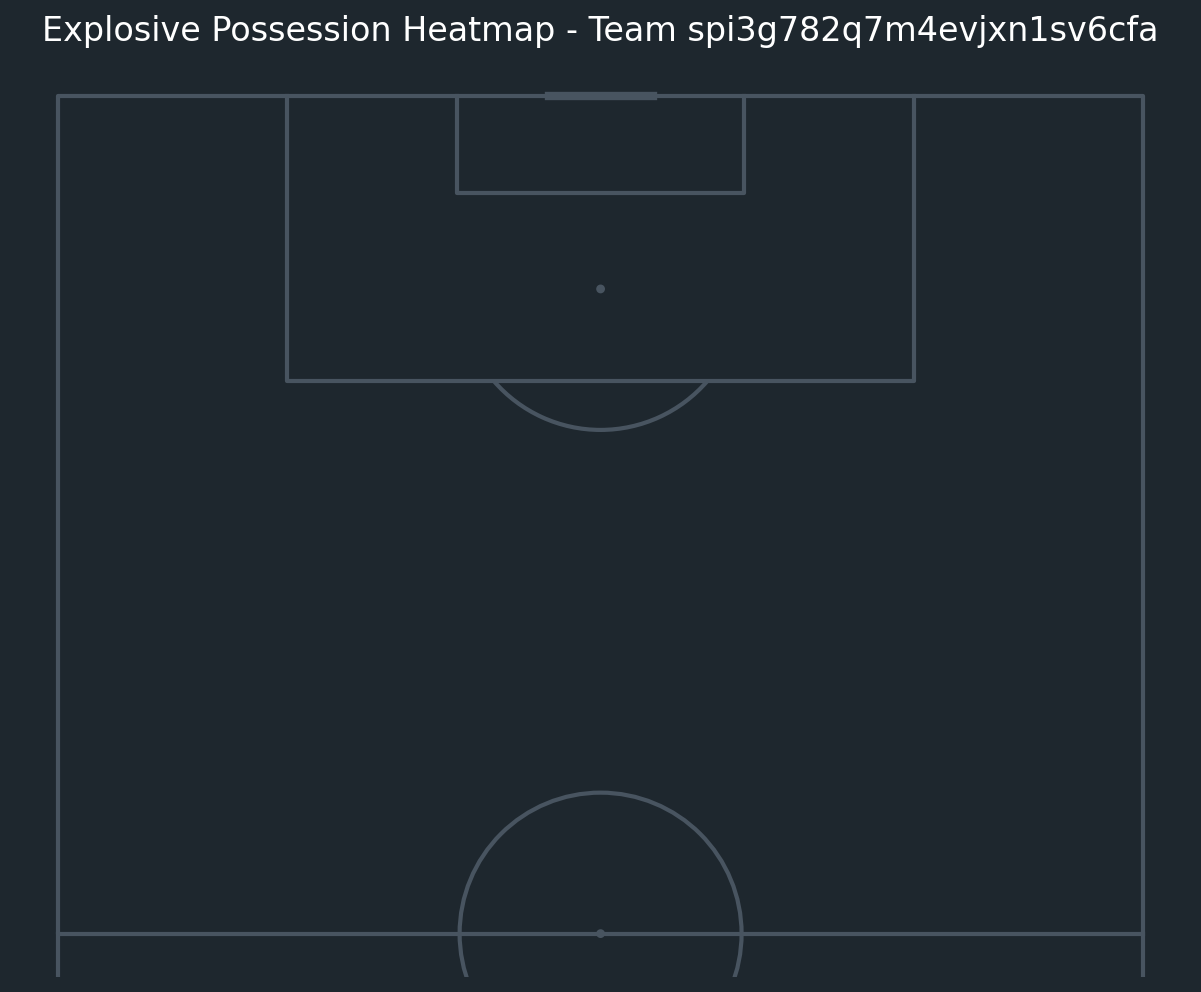

In [4]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch

# -----------------------------------------------------------
# 1️⃣ Load Data
# -----------------------------------------------------------
with open("/Users/user/XG/WSL 2526/2025-09-28_West Ham United WFC - Chelsea FC Women.json", "r") as f:
    match = json.load(f)

events = match["event"]
df = pd.DataFrame(events)

# -----------------------------------------------------------
# 2️⃣ Basic Cleaning
# -----------------------------------------------------------
df["team"] = df["contestantId"]
df["x"] = pd.to_numeric(df.get("x"), errors="coerce")
df["y"] = pd.to_numeric(df.get("y"), errors="coerce")

# -----------------------------------------------------------
# 3️⃣ Possession Segmentation
# -----------------------------------------------------------
plays = []
current_play = []
current_team = None

for _, row in df.iterrows():
    team = row["team"]
    if current_team is None:
        current_team = team

    # Detect possession change
    if team != current_team or row["typeId"] in [1, 2, 3, 4, 5]:
        if current_play:
            plays.append(current_play)
        current_play = [row.to_dict()]
        current_team = team
    else:
        current_play.append(row.to_dict())

if current_play:
    plays.append(current_play)

# -----------------------------------------------------------
# 4️⃣ Metric Functions
# -----------------------------------------------------------

def play_success_rate(play):
    """Binary: did the play reach the final third or create a shot?"""
    xs = [e.get("x", 0) for e in play if e.get("x") is not None]
    final_third = any(x > 66 for x in xs)
    shot = any(e["typeId"] in [13, 14, 15] for e in play)
    return 1 if (final_third or shot) else 0


def extract_xg(play):
    """Extract xG-like qualifier or estimate fallback."""
    for e in play:
        if "qualifier" in e:
            for q in e["qualifier"]:
                if q.get("qualifierId") == 213:  # xG-like qualifier
                    val = float(q.get("value", 0))
                    return min(val, 1.0)
    # Fallback heuristic
    shot_event = next((e for e in play if e["typeId"] in [13, 14, 15]), None)
    if shot_event:
        x = shot_event.get("x", 50)
        base_xg = max(0, (x - 50) / 50) * 0.1
        return round(base_xg, 3)
    return 0.0


def expected_play_value(play):
    """Scaled Expected Play Value (xPV) combining progress + xG."""
    xs = [e.get("x", 0) for e in play if e.get("x") is not None]
    if len(xs) < 2:
        return 0.0
    gain = max(xs) - min(xs)

    # Normalize assuming x is 0–100 (Opta)
    progress_value = (gain / 100) * 0.15  # up to 0.15 for buildup
    shot_value = extract_xg(play)          # up to 1.0 for xG
    xpv = round(min(progress_value + shot_value, 1.0), 4)
    return xpv


def is_negative(play):
    """Possession ends negatively if last event outcome = 0 (fail/loss)."""
    return 1 if play[-1].get("outcome") == 0 else 0


def is_explosive(play):
    """
    Explosive = play includes:
    - a 'rush' (carry/dribble) advancing ≥10m forward, OR
    - a 'pass' advancing ≥20m forward.
    """
    for i, e in enumerate(play):
        etype = e.get("typeId")
        if e.get("x") is None or e.get("y") is None:
            continue
        if i + 1 < len(play):
            next_e = play[i + 1]
            if next_e.get("x") is None:
                continue
            dx = next_e["x"] - e["x"]
            dy = next_e["y"] - e["y"]
            dist = (dx**2 + dy**2)**0.5
            dist_m = dist * 1.05  # 1 pitch % = 1.05 m

            # Passes
            if etype in [8, 9, 10, 11]:  # pass, cross, through ball, etc.
                if dx > 0 and dist_m >= 20:
                    return 1
            # Carries / Dribbles
            elif etype in [19, 20, 21]:  # dribble, carry, run
                if dx > 0 and dist_m >= 10:
                    return 1
    return 0

# -----------------------------------------------------------
# 5️⃣ Collect play-level metrics
# -----------------------------------------------------------
play_metrics = []
for play in plays:
    team = play[0]["team"]
    psr = play_success_rate(play)
    xpv = expected_play_value(play)
    exp = is_explosive(play)
    neg = is_negative(play)

    players = [e.get("playerId") for e in play if e.get("playerId")]
    player_names = [e.get("playerName") for e in play if e.get("playerName")]

    play_metrics.append({
        "team": team,
        "PSR": psr,
        "xPV": xpv,
        "explosive": exp,
        "negative": neg,
        "players": players,
        "player_names": player_names
    })

metrics_df = pd.DataFrame(play_metrics)

# -----------------------------------------------------------
# 6️⃣ Team & Player Aggregations
# -----------------------------------------------------------
team_summary = metrics_df.groupby("team").agg(
    Plays=("PSR", "count"),
    Successful_Plays=("PSR", "sum"),
    PSR_Rate=("PSR", "mean"),
    Total_xPV=("xPV", "sum"),
    Avg_xPV=("xPV", "mean"),
    Explosive_Plays=("explosive", "sum"),
    Negative_Plays=("negative", "sum")
).reset_index()

player_rows = []
for _, row in metrics_df.iterrows():
    for pid, pname in zip(row["players"], row["player_names"]):
        player_rows.append({
            "playerId": pid,
            "playerName": pname,
            "team": row["team"],
            "PSR": row["PSR"],
            "xPV": row["xPV"],
            "explosive": row["explosive"],
            "negative": row["negative"]
        })

players_df = pd.DataFrame(player_rows)

player_summary = players_df.groupby(["playerId", "playerName", "team"]).agg(
    Plays_Involved=("PSR", "count"),
    PSR_Contribution=("PSR", "mean"),
    xPV_Contribution=("xPV", "sum"),
    Explosive_Involved=("explosive", "sum"),
    Negative_Involved=("negative", "sum")
).reset_index()

player_summary["Explosive_Rate"] = player_summary["Explosive_Involved"] / player_summary["Plays_Involved"]
player_summary["Negativity_Rate"] = player_summary["Negative_Involved"] / player_summary["Plays_Involved"]
player_summary = player_summary.sort_values("xPV_Contribution", ascending=False)

# -----------------------------------------------------------
# 7️⃣ Save Results
# -----------------------------------------------------------
team_excel_path = "/Users/user/XG/WSL 2526/WestHam_Chelsea_TeamMetrics.xlsx"
player_excel_path = "/Users/user/XG/WSL 2526/WestHam_Chelsea_PlayerMetrics.xlsx"

team_summary.to_excel(team_excel_path, index=False)
player_summary.to_excel(player_excel_path, index=False)

print("\n🏆 Top 20 Player Contributors (by xPV):\n", player_summary.head(20))
print("\n📊 Team Summary:\n", team_summary)
print(f"\n✅ Team metrics saved to: {team_excel_path}")
print(f"✅ Player metrics saved to: {player_excel_path}")

# -----------------------------------------------------------
# 8️⃣ Visualize Explosive Plays for a Team
# -----------------------------------------------------------
chosen_team = "spi3g782q7m4evjxn1sv6cfa"  # example team ID

explosive_x, explosive_y = [], []

for play in plays:
    if play[0]["team"] == chosen_team and is_explosive(play):
        last_event = play[-1]
        x = last_event.get("x")
        y = last_event.get("y")
        if x is not None and y is not None:
            explosive_x.append(x)
            explosive_y.append(y)

# --- Visualization ---
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 8), dpi=150)
fig.patch.set_facecolor("#1e272e")
ax.set_facecolor("#1e272e")

pitch = VerticalPitch(
    pitch_type='opta',
    half=True,
    pitch_color="#1e272e",
    line_color="#485460",
    axis=False
)
pitch.draw(ax=ax)

pitch.kdeplot(explosive_x, explosive_y, ax=ax, cmap="Reds", shade=True, levels=50, alpha=0.7)
pitch.scatter(explosive_x, explosive_y, ax=ax, c="red", s=30, alpha=0.6)

plt.title(f"Explosive Possession Heatmap - Team {chosen_team}", fontsize=16, color="white")
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/seaborn/distributions.py:198: RuntimeWarning: invalid value encountered in divide
  normalized_values = np.cumsum(sorted_values) / values.sum()


⚠️ KDE warning: Contour levels must be increasing — plotting scatter only.


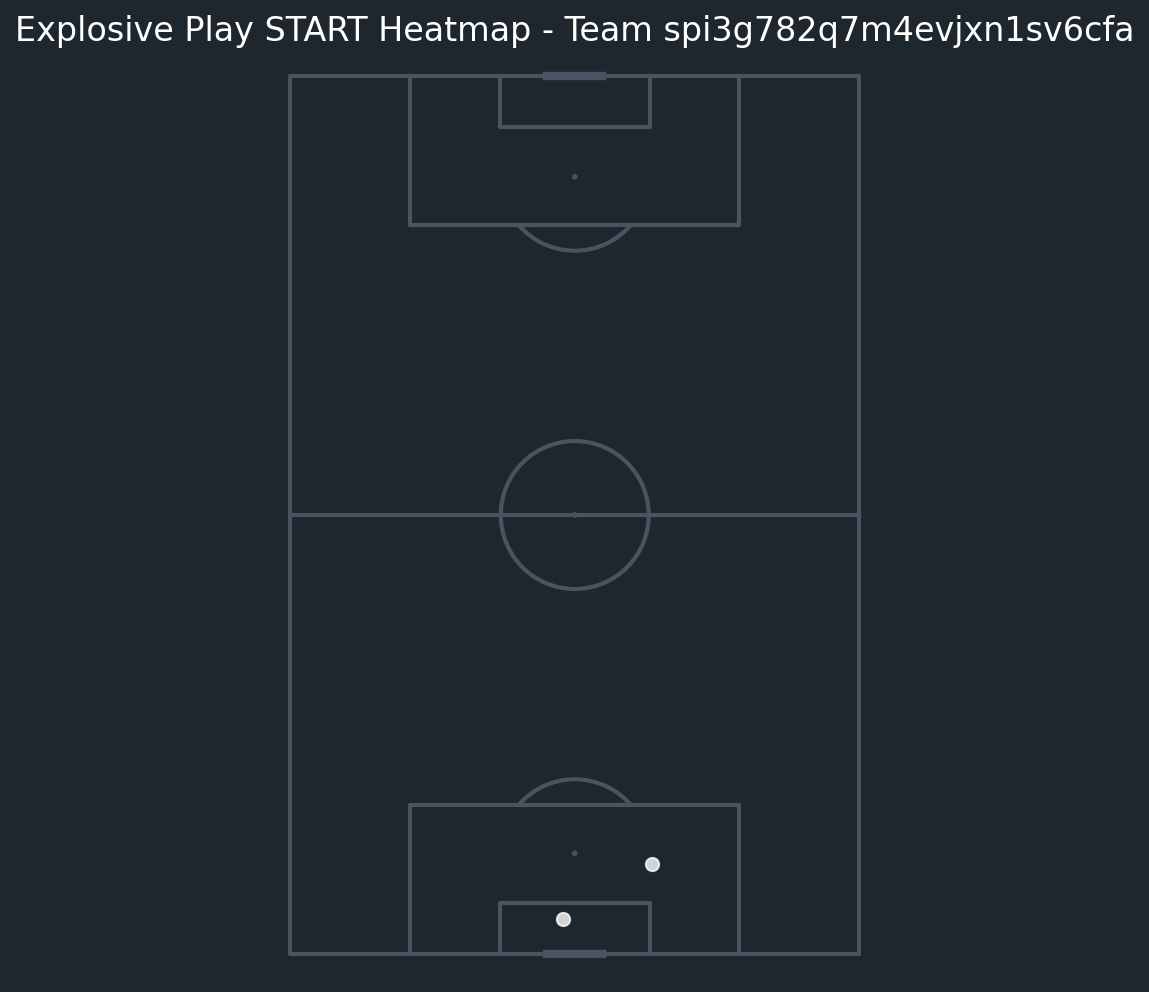

In [10]:
# --- Visualization ---
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12, 8), dpi=150)
fig.patch.set_facecolor("#1e272e")
ax.set_facecolor("#1e272e")

pitch = VerticalPitch(
    pitch_type='opta',
    half=False,
    pitch_color="#1e272e",
    line_color="#485460",
    axis=False
)
pitch.draw(ax=ax)

# --- Robust KDE: skip if too few data points ---
if len(explosive_start_x) >= 2:  # need at least 3 for KDE
    try:
        pitch.kdeplot(
            explosive_start_x,
            explosive_start_y,
            ax=ax,
            cmap="Reds",
            fill=True,          # modern replacement for shade=True
            levels=np.linspace(0.05, 1.0, 25),  # ✅ guaranteed increasing
            alpha=0.7,
            thresh=0.05,
        )
    except ValueError as e:
        print(f"⚠️ KDE warning: {e} — plotting scatter only.")
        pitch.scatter(explosive_start_x, explosive_start_y, ax=ax, c="white", s=40, alpha=0.8)
else:
    print(f"⚠️ Too few explosive plays ({len(explosive_start_x)}) for KDE — showing scatter only.")
    pitch.scatter(explosive_start_x, explosive_start_y, ax=ax, c="white", s=40, alpha=0.8)

plt.title(f"Explosive Play START Heatmap - Team {chosen_team}", fontsize=16, color="white")
plt.show()


In [1]:
import json
import pandas as pd
import numpy as np

# --- Load data ---
with open("/Users/user/XG/WSL 2526/2025-09-28_West Ham United WFC - Chelsea FC Women.json", "r") as f:
    match = json.load(f)

events = match["event"]
df = pd.DataFrame(events)

# --- Basic cleaning ---
df["team"] = df["contestantId"]
df["x"] = pd.to_numeric(df.get("x"), errors="coerce")
df["y"] = pd.to_numeric(df.get("y"), errors="coerce")

# --- Possession Segmentation ---
plays = []
current_play = []
current_team = None

for _, row in df.iterrows():
    team = row["team"]
    if current_team is None:
        current_team = team

    # Change of possession if team switches or restart-type event occurs
    if team != current_team or row["typeId"] in [1, 2, 3, 4, 5]:
        if current_play:
            plays.append(current_play)
        current_play = [row.to_dict()]
        current_team = team
    else:
        current_play.append(row.to_dict())

if current_play:
    plays.append(current_play)

# --- Metric Functions ---

def play_success_rate(play):
    """Binary: did the play reach the final third or create a shot?"""
    xs = [e.get("x", 0) for e in play if e.get("x") is not None]
    final_third = any(x > 66 for x in xs)
    shot = any(e["typeId"] in [13, 14, 15] for e in play)
    return 1 if (final_third or shot) else 0


def extract_xg(play):
    """Extract xG-like qualifier or estimate a small heuristic fallback."""
    for e in play:
        if "qualifier" in e:
            for q in e["qualifier"]:
                if q.get("qualifierId") == 213:  # xG-like qualifier
                    val = float(q.get("value", 0))
                    return min(val, 1.0)
    # Fallback heuristic if no xG data
    shot_event = next((e for e in play if e["typeId"] in [13, 14, 15]), None)
    if shot_event:
        x = shot_event.get("x", 50)
        base_xg = max(0, (x - 50) / 50) * 0.1
        return round(base_xg, 3)
    return 0.0


def expected_play_value(play):
    """Scaled Expected Play Value (xPV) combining progress + xG."""
    xs = [e.get("x", 0) for e in play if e.get("x") is not None]
    if len(xs) < 2:
        return 0.0
    gain = max(xs) - min(xs)

    # Normalize: assume 0–100 scale for pitch x coordinates
    progress_value = (gain / 100) * 0.15  # max 0.15 from buildup
    shot_value = extract_xg(play)          # up to 1.0 from shot

    xpv = progress_value + shot_value
    xpv = round(min(xpv, 1.0), 4)          # cap to 1.0

    # sanity check for bad data
    if xpv > 1:
        print(f"⚠️ Unusual xPV {xpv:.2f} for play: gain={gain:.1f}, shot_value={shot_value}")
    return xpv


def is_explosive(play):
    """Define explosiveness as high progression or significant xPV."""
    xs = [e.get("x", 0) for e in play if e.get("x") is not None]
    if not xs:
        return 0
    gain = max(xs) - min(xs)
    
    # Adjusted explosiveness criteria: lowered thresholds for explosiveness
    if gain > 20 or expected_play_value(play) > 0.1:  # Lowered the xPV threshold and gain
        return 1
    return 0


def is_negative(play):
    """Possession ends negatively if last event outcome = 0 (fail/loss)."""
    return 1 if play[-1].get("outcome") == 0 else 0


# --- Collect play-level metrics ---
play_metrics = []
for play in plays:
    team = play[0]["team"]
    psr = play_success_rate(play)
    xpv = expected_play_value(play)
    exp = is_explosive(play)
    neg = is_negative(play)

    players = [e.get("playerId") for e in play if e.get("playerId")]
    player_names = [e.get("playerName") for e in play if e.get("playerName")]

    play_metrics.append({
        "team": team,
        "PSR": psr,
        "xPV": xpv,
        "explosive": exp,
        "negative": neg,
        "players": players,
        "player_names": player_names
    })

metrics_df = pd.DataFrame(play_metrics)

# --- Team-level summary ---
team_summary = metrics_df.groupby("team").agg(
    Plays=("PSR", "count"),
    Successful_Plays=("PSR", "sum"),
    PSR_Rate=("PSR", "mean"),
    Total_xPV=("xPV", "sum"),
    Avg_xPV=("xPV", "mean"),
    Explosive_Plays=("explosive", "sum"),
    Negative_Plays=("negative", "sum")
).reset_index()

# Add explosive play contribution to team summary (weighted by average xPV)
team_summary["Explosive_Play_Contribution"] = team_summary["Explosive_Plays"] * team_summary["Avg_xPV"]

# --- Player-level aggregation ---
player_rows = []
for _, row in metrics_df.iterrows():
    for pid, pname in zip(row["players"], row["player_names"]):
        player_rows.append({
            "playerId": pid,
            "playerName": pname,
            "team": row["team"],
            "PSR": row["PSR"],
            "xPV": row["xPV"],
            "explosive": row["explosive"],
            "negative": row["negative"]
        })

players_df = pd.DataFrame(player_rows)

player_summary = players_df.groupby(["playerId", "playerName", "team"]).agg(
    Plays_Involved=("PSR", "count"),
    PSR_Contribution=("PSR", "mean"),
    xPV_Contribution=("xPV", "sum"),
    Explosive_Involved=("explosive", "sum"),
    Negative_Involved=("negative", "sum")
).reset_index()

# Derived ratios
player_summary["Explosive_Rate"] = player_summary["Explosive_Involved"] / player_summary["Plays_Involved"]
player_summary["Negativity_Rate"] = player_summary["Negative_Involved"] / player_summary["Plays_Involved"]

# Clip extreme values just in case
player_summary["xPV_Contribution"] = player_summary["xPV_Contribution"].clip(upper=5)

# Add explosive play impact to player summary (weighted by xPV contribution)
player_summary["Explosive_Play_Impact"] = player_summary["Explosive_Involved"] * player_summary["xPV_Contribution"]

# Sort by main contribution metric
player_summary = player_summary.sort_values("xPV_Contribution", ascending=False)

# --- Output summaries ---
print("\n🏆 Top 20 Player Contributors (by xPV):\n")
print(player_summary.head(20))

print("\n📊 Team Summary:\n")
print(team_summary)

# --- Save to Excel ---
team_excel_path = "/Users/user/XG/WSL 2526/WestHam_Chelsea_TeamMetrics.xlsx"
player_excel_path = "/Users/user/XG/WSL 2526/WestHam_Chelsea_PlayerMetrics.xlsx"

team_summary.to_excel(team_excel_path, index=False)
player_summary.to_excel(player_excel_path, index=False)

print(f"\n✅ Team metrics saved to: {team_excel_path}")
print(f"✅ Player metrics saved to: {player_excel_path}")



🏆 Top 20 Player Contributors (by xPV):

                     playerId          playerName                       team  \
15  a5ew0j9hz4ounrjkeco7g6iuh             R. Ueki  cz26xwowfjp8ei14n9z2ac135   
14  8h7r4d4z2gjne58xwu3koiok5            K. Walsh   spi3g782q7m4evjxn1sv6cfa   
29  f1xb9y38jfjmrhgv22svv9sa2           A. Denton  cz26xwowfjp8ei14n9z2ac135   
26  e93vn46w6kk9xwdb8forgzil1           V. Asseyi  cz26xwowfjp8ei14n9z2ac135   
25  e3n8fh86gv7xkw2zi6jlqelzp            K. Gorry  cz26xwowfjp8ei14n9z2ac135   
24  dxojafbkfxjskl0ek4nucrnpx           K. Szemik  cz26xwowfjp8ei14n9z2ac135   
23  dtadpzl4ocembhsgou8zjsjjd           F. Morgan  cz26xwowfjp8ei14n9z2ac135   
22  dm9vc2mqtbb982sx6kkd992ax        S. Baltimore   spi3g782q7m4evjxn1sv6cfa   
21  dfeohozpw604y5jbu01u1dkkq         A. Thompson   spi3g782q7m4evjxn1sv6cfa   
19  cs3pg64kurip4uftscemh01k9           A. Tysiak  cz26xwowfjp8ei14n9z2ac135   
18  cij18xj0bx2zyx3mi9xwykn9x         E. Cuthbert   spi3g782q7m4evjxn1sv6cfa   

In [7]:
import json
import pandas as pd
import numpy as np

# --- Load match JSON ---
with open("/Users/user/XG/WSL 2526/2025-09-28_West Ham United WFC - Chelsea FC Women.json", "r") as f:
    match = json.load(f)

events = match["event"]
df = pd.DataFrame(events)

# --- Basic cleaning ---
df["team"] = df["contestantId"]
df["x"] = pd.to_numeric(df.get("x"), errors="coerce")
df["y"] = pd.to_numeric(df.get("y"), errors="coerce")

# Extract endX and endY when typeId == 1 and qualifiers 140/141
df["endX"] = np.nan
df["endY"] = np.nan
for i, row in df.iterrows():
    if row["typeId"] == 1 and "qualifier" in row and isinstance(row["qualifier"], list):
        for q in row["qualifier"]:
            if q.get("qualifierId") == 140:
                df.at[i, "endX"] = float(q.get("value", np.nan))
            elif q.get("qualifierId") == 141:
                df.at[i, "endY"] = float(q.get("value", np.nan))

# --- Possession segmentation ---
plays = []
current_play = []
current_team = None

for _, row in df.iterrows():
    team = row["team"]
    if current_team is None:
        current_team = team

    # Change of possession if team switches or restart-type event occurs
    if team != current_team or row["typeId"] in [1, 2, 3, 4, 5]:
        if current_play:
            plays.append(current_play)
        current_play = [row.to_dict()]
        current_team = team
    else:
        current_play.append(row.to_dict())

if current_play:
    plays.append(current_play)

# --- Metric functions ---
def play_success_rate(play):
    xs = [e.get("x", 0) for e in play if e.get("x") is not None]
    final_third = any(x > 66 for x in xs)
    shot = any(e["typeId"] in [13, 14, 15] for e in play)
    return 1 if (final_third or shot) else 0

def extract_xg(play):
    for e in play:
        if "qualifier" in e:
            for q in e["qualifier"]:
                if q.get("qualifierId") == 213:
                    val = float(q.get("value", 0))
                    return min(val, 1.0)
    shot_event = next((e for e in play if e["typeId"] in [13, 14, 15]), None)
    if shot_event:
        x = shot_event.get("x", 50)
        base_xg = max(0, (x - 50) / 50) * 0.1
        return round(base_xg, 3)
    return 0.0

def expected_play_value(play):
    xs = [e.get("x", 0) for e in play if e.get("x") is not None]
    if len(xs) < 2:
        return 0.0
    gain = max(xs) - min(xs)
    progress_value = (gain / 100) * 0.15
    shot_value = extract_xg(play)
    xpv = progress_value + shot_value
    return round(min(xpv, 1.0), 4)

def is_explosive(play):
    xs = [e.get("x", 0) for e in play if e.get("x") is not None]
    if not xs:
        return 0
    gain = max(xs) - min(xs)
    return 1 if gain > 20 or expected_play_value(play) > 0.1 else 0

def is_negative(play):
    return 1 if play[-1].get("outcome") == 0 else 0

# --- Collect play-level metrics ---
play_metrics = []
for play in plays:
    team = play[0]["team"]
    psr = play_success_rate(play)
    xpv = expected_play_value(play)
    exp = is_explosive(play)
    neg = is_negative(play)

    players = [e.get("playerId") for e in play if e.get("playerId")]
    player_names = [e.get("playerName") for e in play if e.get("playerName")]

    play_metrics.append({
        "team": team,
        "PSR": psr,
        "xPV": xpv,
        "explosive": exp,
        "negative": neg,
        "players": players,
        "player_names": player_names
    })

metrics_df = pd.DataFrame(play_metrics)

# --- Team-level summary ---
team_summary = metrics_df.groupby("team").agg(
    Plays=("PSR", "count"),
    Successful_Plays=("PSR", "sum"),
    PSR_Rate=("PSR", "mean"),
    Total_xPV=("xPV", "sum"),
    Avg_xPV=("xPV", "mean"),
    Explosive_Plays=("explosive", "sum"),
    Negative_Plays=("negative", "sum")
).reset_index()

team_summary["Explosive_Play_Contribution"] = team_summary["Explosive_Plays"] * team_summary["Avg_xPV"]

# --- Player-level summary ---
player_rows = []
for _, row in metrics_df.iterrows():
    for pid, pname in zip(row["players"], row["player_names"]):
        player_rows.append({
            "playerId": pid,
            "playerName": pname,
            "team": row["team"],
            "PSR": row["PSR"],
            "xPV": row["xPV"],
            "explosive": row["explosive"],
            "negative": row["negative"]
        })

players_df = pd.DataFrame(player_rows)

player_summary = players_df.groupby(["playerId", "playerName", "team"]).agg(
    Plays_Involved=("PSR", "count"),
    PSR_Contribution=("PSR", "mean"),
    xPV_Contribution=("xPV", "sum"),
    Explosive_Involved=("explosive", "sum"),
    Negative_Involved=("negative", "sum")
).reset_index()

player_summary["Explosive_Rate"] = player_summary["Explosive_Involved"] / player_summary["Plays_Involved"]
player_summary["Negativity_Rate"] = player_summary["Negative_Involved"] / player_summary["Plays_Involved"]
player_summary["xPV_Contribution"] = player_summary["xPV_Contribution"].clip(upper=5)
player_summary["Explosive_Play_Impact"] = player_summary["Explosive_Involved"] * player_summary["xPV_Contribution"]

# --- Advanced Indices (0–1 normalized) ---
for df_ in [player_summary, team_summary]:
    for col in df_.select_dtypes(include=[np.number]).columns:
        if col not in ["Plays_Involved", "Plays"]:
            min_val, max_val = df_[col].min(), df_[col].max()
            if max_val > min_val:
                df_[col + "_norm"] = (df_[col] - min_val) / (max_val - min_val)
            else:
                df_[col + "_norm"] = 0.5

# Player-level indices
player_summary["Efficiency_Index"] = (player_summary["PSR_Contribution_norm"] + player_summary["xPV_Contribution_norm"]) / 2
player_summary["Momentum_Value"] = (player_summary["Explosive_Rate_norm"] + player_summary["xPV_Contribution_norm"]) / 2
player_summary["Explosive_Impact_Rating"] = (player_summary["Explosive_Play_Impact_norm"]) 
player_summary["Stability_Factor"] = 1 - player_summary["Negativity_Rate_norm"]
player_summary["Total_Value_Index"] = (player_summary["Efficiency_Index"] + player_summary["Momentum_Value"] + player_summary["Stability_Factor"]) / 3

# Team-level indices
team_summary["Efficiency_Index"] = (team_summary["PSR_Rate_norm"] + team_summary["Avg_xPV_norm"]) / 2
team_summary["Momentum_Value"] = (team_summary["Explosive_Plays_norm"] + team_summary["Explosive_Play_Contribution_norm"]) / 2
team_summary["Explosive_Impact_Rating"] = team_summary["Explosive_Play_Contribution_norm"]
team_summary["Stability_Factor"] = 1 - team_summary["Negative_Plays_norm"]
team_summary["Total_Value_Index"] = (team_summary["Efficiency_Index"] + team_summary["Momentum_Value"] + team_summary["Stability_Factor"]) / 3

# --- Sequence-level data ---
sequence_data = []
for i, play in enumerate(plays, start=1):
    team = play[0]["team"]
    psr = play_success_rate(play)
    xpv = expected_play_value(play)
    exp = is_explosive(play)
    neg = is_negative(play)
    players = [e.get("playerName") for e in play if e.get("playerName")]

    xs = [e.get("x") for e in play if e.get("x") is not None]
    ys = [e.get("y") for e in play if e.get("y") is not None]
    endxs = [e.get("endX") for e in play if e.get("endX") is not None]
    endys = [e.get("endY") for e in play if e.get("endY") is not None]

    startX = xs[0] if xs else np.nan
    startY = ys[0] if ys else np.nan
    endX = endxs[-1] if endxs else (xs[-1] if xs else np.nan)
    endY = endys[-1] if endys else (ys[-1] if ys else np.nan)

    sequence_data.append({
        "sequenceId": i,
        "team": team,
        "PSR": psr,
        "xPV": xpv,
        "explosive": exp,
        "negative": neg,
        "startX": startX,
        "startY": startY,
        "endX": endX,
        "endY": endY,
        "players_involved": ", ".join(sorted({str(p) for p in players if pd.notna(p)}))
    })

sequence_df = pd.DataFrame(sequence_data)


# --- Save all outputs ---
team_excel_path = "/Users/user/XG/WSL 2526/WestHam_Chelsea_TeamMetrics.xlsx"
player_excel_path = "/Users/user/XG/WSL 2526/WestHam_Chelsea_PlayerMetrics.xlsx"
sequence_excel_path = "/Users/user/XG/WSL 2526/WestHam_Chelsea_Sequences.xlsx"

team_summary.to_excel(team_excel_path, index=False)
player_summary.to_excel(player_excel_path, index=False)
sequence_df.to_excel(sequence_excel_path, index=False)

print("\n✅ All metrics exported successfully!")
print(f"🏆 Player metrics → {player_excel_path}")
print(f"📊 Team metrics → {team_excel_path}")
print(f"🎯 Sequence data → {sequence_excel_path}")



✅ All metrics exported successfully!
🏆 Player metrics → /Users/user/XG/WSL 2526/WestHam_Chelsea_PlayerMetrics.xlsx
📊 Team metrics → /Users/user/XG/WSL 2526/WestHam_Chelsea_TeamMetrics.xlsx
🎯 Sequence data → /Users/user/XG/WSL 2526/WestHam_Chelsea_Sequences.xlsx


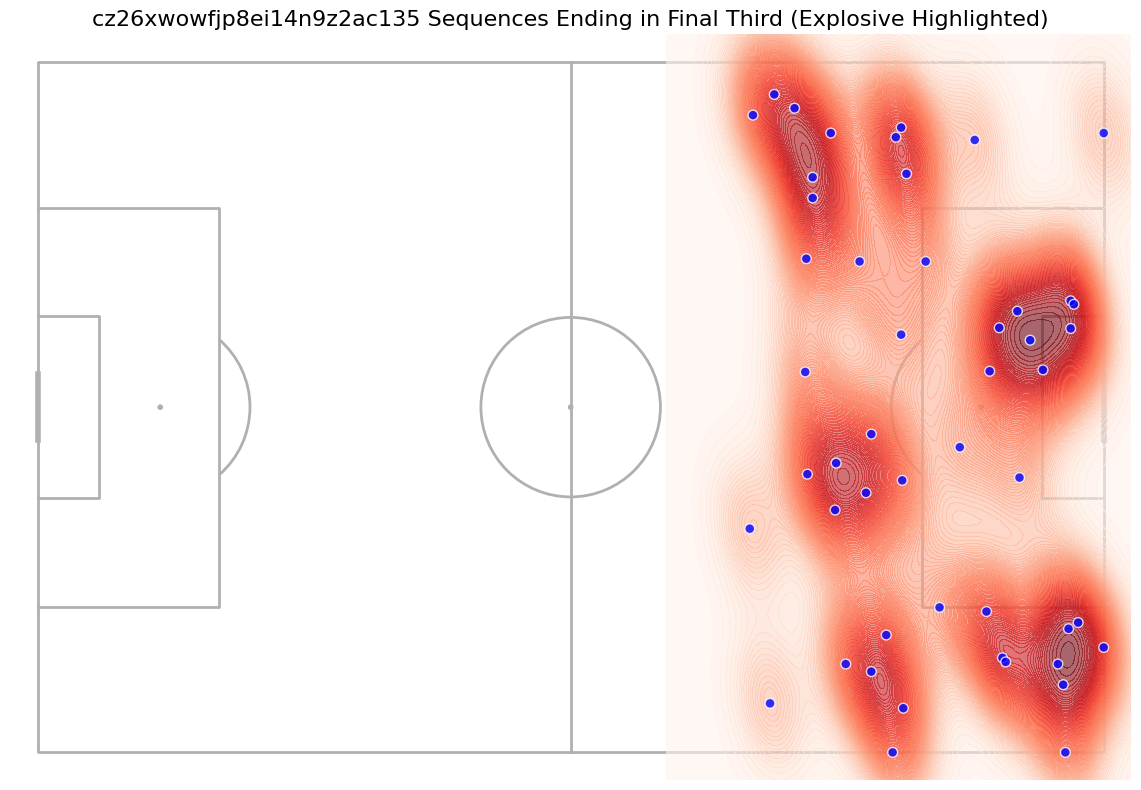

In [13]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import seaborn as sns

# --- Filter sequences ending in final third ---
final_third_sequences = sequence_df[sequence_df["endX"] > 66]

# --- Choose a team to plot ---
team_to_plot = team_summary["team"].iloc[0]  # first team
team_sequences = final_third_sequences[final_third_sequences["team"] == team_to_plot]

# --- Extract coordinates and explosive rating ---
x_coords_team = team_sequences["endX"].dropna()
y_coords_team = team_sequences["endY"].dropna()
explosive_rating = team_sequences["explosive"].fillna(0)  # 0 or 1

# --- Create pitch ---
pitch = Pitch(pitch_type='opta', pitch_length=100, pitch_width=68)
fig, ax = pitch.draw(figsize=(12, 8))

# --- Heatmap with radial circles ---
sns.kdeplot(
    x=x_coords_team, y=y_coords_team,
    fill=True, thresh=0, levels=100,
    cmap="Reds", alpha=0.6, bw_adjust=0.5,
    ax=ax
)

# --- Overlay sequence end points with explosive rating ---
# Explosive sequences larger and darker
sizes = 50 + explosive_rating * 100  # base size 50, +100 if explosive
colors = ['blue' if e==0 else 'orange' for e in explosive_rating]  # orange for explosive

ax.scatter(x_coords_team, y_coords_team, s=sizes, color=colors, edgecolor="white", alpha=0.8)

# --- Title ---
ax.set_title(f"{team_to_plot} Sequences Ending in Final Third (Explosive Highlighted)", fontsize=16)
plt.show()


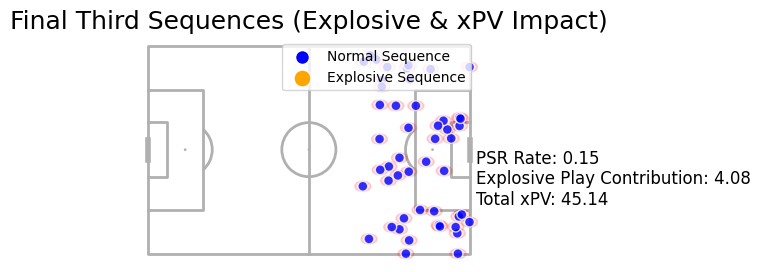

In [27]:
from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import numpy as np

# --- Filter sequences ending in final third ---
final_third_sequences = sequence_df[sequence_df["endX"] > 66]

# --- Choose a team to plot ---
team_to_plot = team_summary["team"].iloc[0]  # first team
team_sequences = final_third_sequences[final_third_sequences["team"] == team_to_plot]

# --- Extract coordinates and explosive rating ---
x_coords = team_sequences["endX"].dropna().values
y_coords = team_sequences["endY"].dropna().values
explosive = team_sequences["explosive"].fillna(0).values
xpv = team_sequences["xPV"].fillna(0).values

# --- Scale marker sizes by xPV and explosiveness ---
sizes = 50 + xpv * 200 + explosive * 150  # base + xPV + explosive bonus
colors = ["orange" if e==1 else "blue" for e in explosive]

# --- Create pitch ---
pitch = Pitch(pitch_type='opta', pitch_length=100, pitch_width=68,)
fig, ax = pitch.draw()

# --- Draw radial impact circles for each sequence ---
for xi, yi, si in zip(x_coords, y_coords, sizes):
    circle = plt.Circle((xi, yi), si*0.05, color='red', alpha=0.15)
    ax.add_patch(circle)

# --- Overlay sequence end points ---
ax.scatter(x_coords, y_coords, s=sizes, color=colors, edgecolor='white', alpha=0.8)

# --- Team Metrics Annotations ---
team_metrics = team_summary[team_summary["team"] == team_to_plot].iloc[0]
metrics_text = (
    f"PSR Rate: {team_metrics['PSR_Rate']:.2f}\n"
    f"Explosive Play Contribution: {team_metrics['Explosive_Play_Contribution']:.2f}\n"
    f"Total xPV: {team_metrics['Total_xPV']:.2f}"
)
ax.text(102, 50, metrics_text, fontsize=12, color='black', va='top')

# --- Legend ---
ax.scatter([], [], s=100, color='blue', edgecolor='white', label='Normal Sequence')
ax.scatter([], [], s=150, color='orange', edgecolor='white', label='Explosive Sequence')
ax.legend(loc='upper right', frameon=True)

# --- Title ---
ax.set_title(f"Final Third Sequences (Explosive & xPV Impact)", fontsize=18)
plt.show()
